![MLU Logo](../../data/MLU_Logo.png)

# <a name="0">Responsible AI - Exploratory Data Analysis</a>

This notebook shows how to quantify and visualize correlations (scatter plots, correlation matrix) and generate descriptive statistics (histograms and bar plots). To measure bias before training a model, we will use $CI_{norm}$ and $DPL$. These are just example measure that can be used pre-training. Make sure to try more measures when building a model.

__Dataset:__ 
You will download a dataset for this exercise using [folktables](https://github.com/zykls/folktables). Folktables provides an API to download data from the American Community Survey (ACS) Public Use Microdata Sample (PUMS) files which are managed by the US Census Bureau. The data itself is governed by the terms of use provided by the Census Bureau. For more information, see the [Terms of Service](https://www.census.gov/data/developers/about/terms-of-service.html).


__ML Problem:__ 
Ultimately, the goal will be to predict whether an individual's income is above \\$50,000. We will  filter the ACS PUMS data sample to only include individuals above the age of 16, who reported usual working hours of at least 1 hour per week in the past year, and an income of at least \\$100. The threshold of \\$50,000 was chosen so that this dataset can serve as a comparable substitute to the [UCI Adult dataset](https://archive.ics.uci.edu/ml/datasets/adult). The income threshold can be changed easily to define new prediction tasks.

__Table of contents__

1. <a href="#1">Loading Data</a>
2. <a href="#2">Data Overview</a>
3. <a href="#3">Bar Plots \& Histograms</a>
4. <a href="#4">Scatter Plots</a>
5. <a href="#5">Correlation Matrix</a>
5. <a href="#6">$CI_{norm}$ and $DPL$</a>

This notebook assumes an installation of the SageMaker kernel `conda_pytorch_p39`. In addition, libraries from a requirements.txt need to be installed:

In [1]:
!pip install --no-deps -U -q -r ../../requirements.txt

ERROR: Ignored the following yanked versions: 1.11.0, 1.14.0rc1
ERROR: Ignored the following versions that require a different python version: 1.21.2 Requires-Python >=3.7,<3.11; 1.21.3 Requires-Python >=3.7,<3.11; 1.21.4 Requires-Python >=3.7,<3.11; 1.21.5 Requires-Python >=3.7,<3.11; 1.21.6 Requires-Python >=3.7,<3.11; 1.6.2 Requires-Python >=3.7,<3.10; 1.6.3 Requires-Python >=3.7,<3.10; 1.7.0 Requires-Python >=3.7,<3.10; 1.7.1 Requires-Python >=3.7,<3.10; 1.7.2 Requires-Python >=3.7,<3.11; 1.7.3 Requires-Python >=3.7,<3.11; 1.8.0 Requires-Python >=3.8,<3.11; 1.8.0rc1 Requires-Python >=3.8,<3.11; 1.8.0rc2 Requires-Python >=3.8,<3.11; 1.8.0rc3 Requires-Python >=3.8,<3.11; 1.8.0rc4 Requires-Python >=3.8,<3.11; 1.8.1 Requires-Python >=3.8,<3.11
ERROR: Could not find a version that satisfies the requirement scipy==1.7.2 (from versions: 0.8.0, 0.9.0, 0.10.0, 0.10.1, 0.11.0, 0.12.0, 0.12.1, 0.13.0, 0.13.1, 0.13.2, 0.13.3, 0.14.0, 0.14.1, 0.15.0, 0.15.1, 0.16.0, 0.16.1, 0.17.0, 0.17.1, 0.18

In [3]:
# Reshaping/basic libraries
import pandas as pd

# Plotting libraries
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style("darkgrid", {"axes.facecolor": ".9"})

# Operational libraries
import sys

sys.path.append("..")

# Fairness libraries
from folktables.acs import *
from folktables.folktables import *
from folktables.load_acs import *

# Jupyter(lab) libraries
import warnings

warnings.filterwarnings("ignore")

## 1. <a name="1">Loading Data</a>
(<a href="#0">Go to top</a>)

To read in the dataset, we will be using [folktables](https://github.com/zykls/folktables) which provides access to the US Census dataset. Folktables contains predefined prediction tasks but also allows the user to specify the problem type.

The US Census dataset distinguishes between household and individuals. To obtain data on individuals, we use `ACSDataSource` with `survey=person`. The feature names for the US Census data follow the same distinction and use `P` for `person` and `H` for `household`, e.g.: `AGEP` refers to age of an individual.

In [4]:
income_features = [
    "AGEP",  # age individual
    "COW",  # class of worker
    "SCHL",  # educational attainment
    "MAR",  # marital status
    "OCCP",  # occupation
    "POBP",  # place of birth
    "RELP",  # relationship
    "WKHP",  # hours worked per week past 12 months
    "SEX",  # sex
    "RAC1P",  # recorded detailed race code
    "PWGTP",  # persons weight
    "GCL",  # grandparents living with grandchildren
    "SCH",  # school enrollment
]

# Define the prediction problem and features
ACSIncome = folktables.BasicProblem(
    features=income_features,
    target="PINCP",  # total persons income
    target_transform=lambda x: x > 50000,
    group="RAC1P",
    preprocess=adult_filter,  # applies the following conditions; ((AAGE>16) && (AGI>100) && (AFNLWGT>1)&& (HRSWK>0))
    postprocess=lambda x: x,  # applies post processing, e.g. fill all NAs
)

# Initialize year, duration ("1-Year" or "5-Year") and granularity (household or person)
data_source = ACSDataSource(survey_year="2018", horizon="1-Year", survey="person")
# Specify region (here: California) and load data
ca_data = data_source.get_data(states=["CA"], download=True)
# Apply transformation as per problem statement above
ca_features, ca_labels, ca_group = ACSIncome.df_to_numpy(ca_data)

## 2. <a name="2">Data Overview</a>
(<a href="#0">Go to top</a>)

We want to go through basic steps of exploratory data analysis (EDA), performing initial data investigations to discover patterns, spot anomalies, and look for insights to inform later ML modeling choices.

In [5]:
# Convert numpy array to dataframe
df = pd.DataFrame(
    np.concatenate((ca_features, ca_labels.reshape(-1, 1)), axis=1),
    columns=income_features + [">50k"],
)

# Print the first five rows
# NaN means missing data
df.head()

,AGEP,COW,SCHL,MAR,OCCP,POBP,RELP,WKHP,SEX,RAC1P,PWGTP,GCL,SCH,>50k
0,30.0,6.0,14.0,1.0,9610.0,6.0,16.0,40.0,1.0,8.0,32.0,2.0,1.0,0.0
1,21.0,4.0,16.0,5.0,1970.0,6.0,17.0,20.0,1.0,1.0,52.0,NaN,2.0,0.0
2,65.0,2.0,22.0,5.0,2040.0,6.0,17.0,8.0,1.0,1.0,33.0,2.0,1.0,0.0
3,33.0,1.0,14.0,3.0,9610.0,36.0,16.0,40.0,1.0,1.0,53.0,2.0,1.0,0.0
4,18.0,2.0,19.0,5.0,1021.0,6.0,17.0,18.0,2.0,1.0,106.0,NaN,3.0,0.0


In [6]:
# Check how many rows and columns we have in the data frame
print("The shape of the dataset is:", df.shape)

The shape of the dataset is: (195665, 14)


In [7]:
# Let's see the data types and non-null values for each column
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 195665 entries, 0 to 195664
Data columns (total 14 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   AGEP    195665 non-null  float64
 1   COW     195665 non-null  float64
 2   SCHL    195665 non-null  float64
 3   MAR     195665 non-null  float64
 4   OCCP    195665 non-null  float64
 5   POBP    195665 non-null  float64
 6   RELP    195665 non-null  float64
 7   WKHP    195665 non-null  float64
 8   SEX     195665 non-null  float64
 9   RAC1P   195665 non-null  float64
 10  PWGTP   195665 non-null  float64
 11  GCL     149392 non-null  float64
 12  SCH     195665 non-null  float64
 13  >50k    195665 non-null  float64
dtypes: float64(14)
memory usage: 20.9 MB


### 2.1. Casting data
We can clearly see that all columns are numerical (`dtype = float64`). However, when checking the column headers (and information at top of the notebook), we should notice that we are actually dealing with multimodal data. We expect to see a mix of categorical, numerical and potentially even text information.

Let's cast the features accordingly.

In [8]:
categorical_features = [
    "COW",
    "SCHL",
    "MAR",
    "OCCP",
    "POBP",
    "RELP",
    "SEX",
    "RAC1P",
    "GCL",
    "SCH",
]

numerical_features = ["AGEP", "WKHP", "PWGTP"]

One other thing you might notice here are the unintuitive feature names; with a few exceptions it is very difficult to understand what the features refer to; for example `MAR` could refer to March. In this dataset, `MAR` is actually encoding the marital status. It could be worthwhile to rename the features, so it will be easier later to understand what they actually refer to. This can be done by creating a renaming dictionary and by using the Pandas `.rename()` method.

```
# Create dictionary for new column names
rename_dict = {"COW":"worker_class", "SCHL":"educational_attainment"} 

# Apply new names to dataframe
df.rename(rename_dict, axis=1, inplace=True)
```
For now, you can skip this and proceed with the next step of casting the features according to their true data type.

In [9]:
# We cast categorical features to `category`
df[categorical_features] = df[categorical_features].astype("object")

# We cast numerical features to `int`
df[numerical_features] = df[numerical_features].astype("int")

Let's check with `.info()` again to make sure the changes took effect.

In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 195665 entries, 0 to 195664
Data columns (total 14 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   AGEP    195665 non-null  int64  
 1   COW     195665 non-null  object 
 2   SCHL    195665 non-null  object 
 3   MAR     195665 non-null  object 
 4   OCCP    195665 non-null  object 
 5   POBP    195665 non-null  object 
 6   RELP    195665 non-null  object 
 7   WKHP    195665 non-null  int64  
 8   SEX     195665 non-null  object 
 9   RAC1P   195665 non-null  object 
 10  PWGTP   195665 non-null  int64  
 11  GCL     149392 non-null  object 
 12  SCH     195665 non-null  object 
 13  >50k    195665 non-null  float64
dtypes: float64(1), int64(3), object(10)
memory usage: 20.9+ MB


Looks good, so we can now separate model features from model target to explore them separately. 

### 2.2. Model Target vs. Model Features

In [11]:
model_target = ">50k"
model_features = categorical_features + numerical_features

print("Model features: ", model_features)
print("Model target: ", model_target)

Model features:  ['COW', 'SCHL', 'MAR', 'OCCP', 'POBP', 'RELP', 'SEX', 'RAC1P', 'GCL', 'SCH', 'AGEP', 'WKHP', 'PWGTP']
Model target:  >50k


In [12]:
# Double check that that target is not accidentally part of the features
model_target in model_features

False

Again, this looks good. You made sure that the target is not in the feature list. If you find the above statement showing `True` you need to remove the target by calling `model_features.remove(model_target)`. Next, you want to start creating some visualizations of the data that you are working with.

### 2.3. Unique instances
Before starting with the plots, let's have a look at how many unique instances we have per column. This helps us avoid plotting charts with hundreds of unique values. Let's filter for columns with fewer than 10 unique categories. Those are the ones we want to plot later.

In [13]:
shortlist_fts = (
    df[model_features]
    .apply(lambda col: col.nunique())
    .where(df[model_features].apply(lambda col: col.nunique()) < 10)
    .dropna()
)

print(shortlist_fts)

COW      8.0
MAR      5.0
SEX      2.0
RAC1P    9.0
GCL      2.0
SCH      3.0
dtype: float64


## 3. <a name="3">Bar Plots \& Histograms</a>
(<a href="#0">Go to top</a>)

In this section, you examine the data with plots. 

- __Important note:__ These plots ignore null (missing) values. As you saw in the section above, there is only one column with `NA` values in our dataset: GCL (grandparents living with grandchildren).

For plotting you need to distinguish between plots for categorical data (bar plots) and plots for numerical data (histograms and scatter plots).

>__Bar plots__: These plots show counts of categorical data fields. The `value_counts()` function yields the counts of each unique value. It is useful for categorical variables. To turn the value count into a plot, simply add `.plot.bar()`.

>__Histograms:__ Histograms show distributions of numeric data. Data is divided into "buckets" or "bins". You use histograms for numerical data to group datapoints together into buckets. The command to create a histogram with 5 buckets is `df[feature_name].plot.hist(bins=5)`.

### 3.1. Bar plots
The features that are eligible for bar plots are all categorical features and also the target feature (which is a binary categorical value). First, let's look at the distribution of the model target.

#### 3.1.1. Target distribution

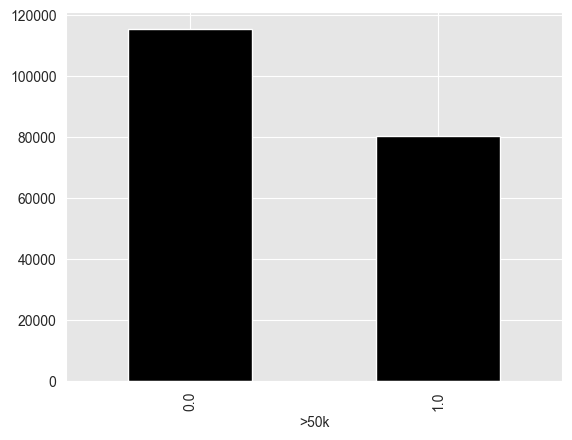

In [14]:
df[model_target].value_counts().plot.bar(color="black")
plt.show()

Keep in mind that we eventually want to build a model that can consider different groups. The sensitive attribute for this example will be the `RAC1P` feature. Let's plot a similar chart but include another dimension. To do this, we need to group by the feature we want to encode. We also want to stack the bar chart to be able to compare to the bar chart above. We will set the `alpha` transparency value below 1 to better see the horizontal grid lines of the plot background.

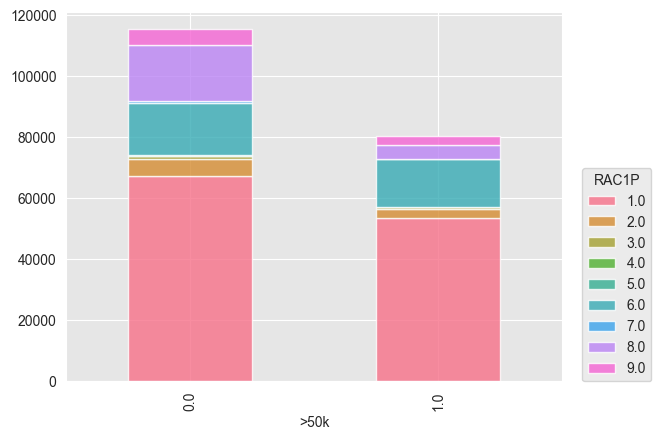

In [15]:
# Set color map for the different categories
cmap = sns.set_palette("husl", 9)

# Perform grouping based on target and feature
df.groupby([model_target, "RAC1P"])["RAC1P"].count().unstack().plot(
    kind="bar", stacked=True, alpha=0.8
)

# Add legend
plt.legend(loc=(1.04, 0), title="RAC1P")
plt.show()

#### 3.1.2. Feature distribution(s)
Let's start exploring other features (so far we only looked at the distribution of the target). The first feature we might want to explore, could be the sensitive attribute itself. It can be helpful to know how many groups we have in a sensitive feature column and how many instances there are per group.

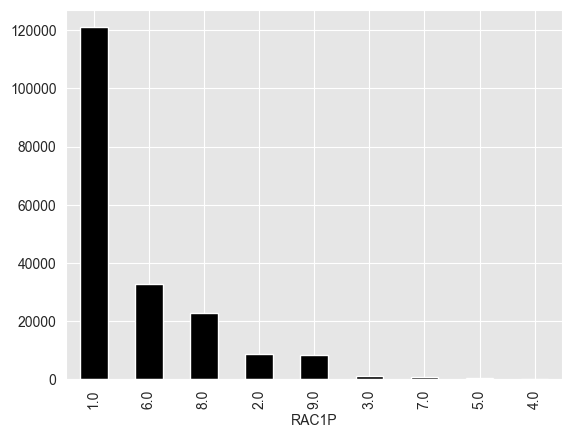

In [16]:
df["RAC1P"].value_counts().plot.bar(color="black")
plt.show()

Let's plot the same chart but include another dimension (the outcome). For this, we want to use another library, Seaborn. Seaborn has a method called `countplot()` which allows to pass a dataframe and feature columns as well as an additional column to use for color encoding.

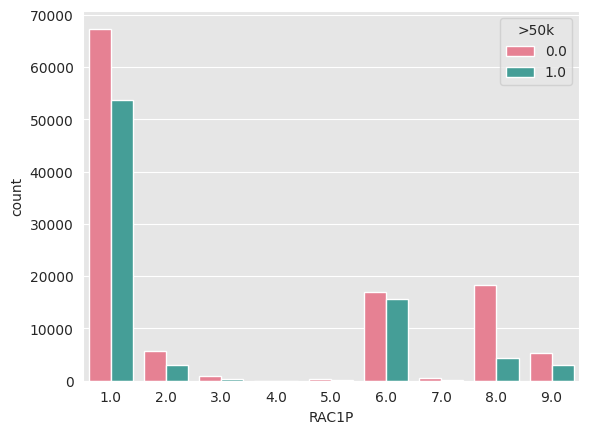

In [16]:
# We want to plot RAC1P on the x-axis and get counts; in addition we color based on model target category
sns.countplot(x="RAC1P", hue=model_target, data=df, palette="husl", dodge=True)

plt.show()

Let's convert these bar charts to percentage numbers to compare the groups more directly. Ultimately, you want to deep dive into the groups with the biggest differences.

In [19]:
# Group by RAC1P feature and count
perc_df = pd.DataFrame(df.groupby("RAC1P")[model_target].value_counts()).rename(
    {model_target: "count"}, axis=1
)

# Calculate percentage total
perc_df["count"] / perc_df.groupby("RAC1P")["count"].transform("sum")

RAC1P  >50k
1.0    0.0     0.556634
       1.0     0.443366
2.0    0.0     0.655136
       1.0     0.344864
3.0    0.0     0.716383
       1.0     0.283617
4.0    0.0     0.615385
       1.0     0.384615
5.0    0.0     0.786667
       1.0     0.213333
6.0    0.0     0.519490
       1.0     0.480510
7.0    0.0     0.701727
       1.0     0.298273
8.0    0.0     0.805730
       1.0     0.194270
9.0    0.0     0.642822
       1.0     0.357178
Name: count, dtype: float64

You can observe that the outcome is not equally distributed across all `RAC1P` categories. The biggest discrepancy appears to be category 8 - for this group there are approx. 4x as many instances of income $\leq$ 50k as above 50k. There are 22793 individuals in group 8. If you compare this to group 6 you should notice that the distribution of outcomes is very different there with an almost 50/50 split for the income levels.

Let's plot another countplot for a feature where we don't expect to see big differences:

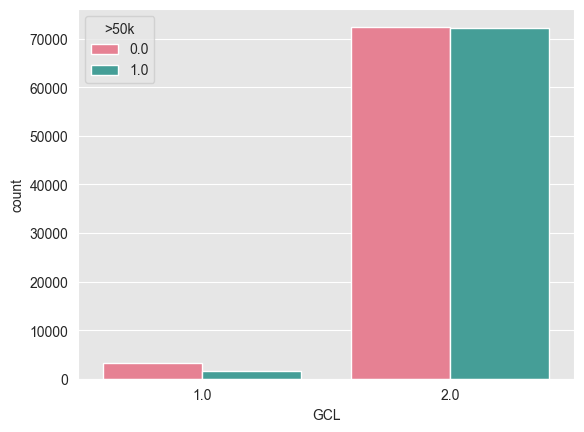

In [20]:
sns.countplot(x="GCL", hue=model_target, data=df, palette="husl", dodge=True)

plt.show()

Another type of barplot can be created with `.catplot()`. This method allows to specify 3 dimensions of encoding at the same time. We can specify the feature that we want counts for (e.g. count of how many instanced for each job category we have), generate comparison columns using a second feature (here `SEX`) and finally encode outcome as color again.

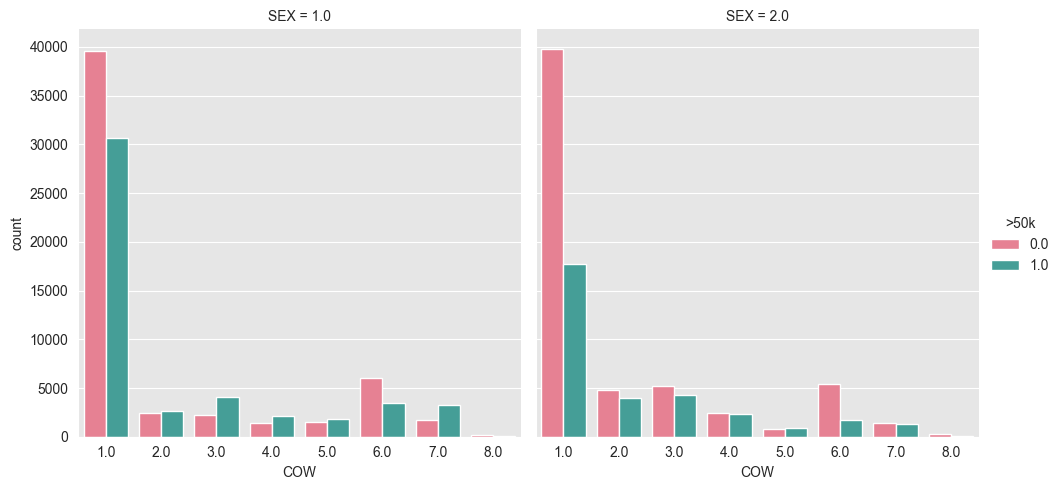

In [21]:
sns.catplot(x="COW", col="SEX", kind="count", hue=model_target, data=df, palette="husl")
plt.show()

The chart above allows us to observe a pay difference by sex and also by work class (job family).

### 3.2. Histograms

Histograms show distributions of numeric data. Data is divided into "buckets" or "bins". We use histograms for numerical data to group datapoints together into buckets. The command to create a histogram is `df[<feature_name>].plot.hist(bins=n)`. Let's try this:

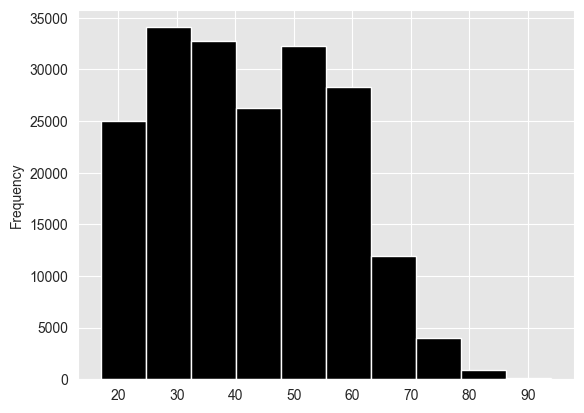

In [22]:
# Let's create 10 bins for analyzing the age feature
df["AGEP"].plot.hist(bins=10, color="black")
plt.show()

You might have expected a lognormal or normal distribution (with peak at around 45 yrs) but are actually observing something that looks like a bi-modal distribution with a cut-off at 16. The cut-off occurs because the `adult_filter` was applied when loading in the dataset in the beginning to mimic the UCI adult dataset; the double peak could indicate that there are 2 different sub-populations in the dataset. Once again, you might want to overlay another feature to check this. You can use Seaborn to do this. 

As you are working with numerical data now, you can to use `.displot()`. There are a lot of things you can specify, for example whether you want percentages, absolute counts, stacking the bars or displaying next to one another. For all the details, take a look at the [seaborn documentation](https://seaborn.pydata.org/generated/seaborn.displot.html). 

This plotting method provides access to different types of histogram plots: 
- 'hist' (histrogram; instance counts per bin), 
- 'kde' (kernel-density-estimation) and 
- 'ecdf' (empirical-cumulative distributions). 

For a comparison of the methods, you can have a look at the [seaborn documentation](https://seaborn.pydata.org/tutorial/distributions.html).

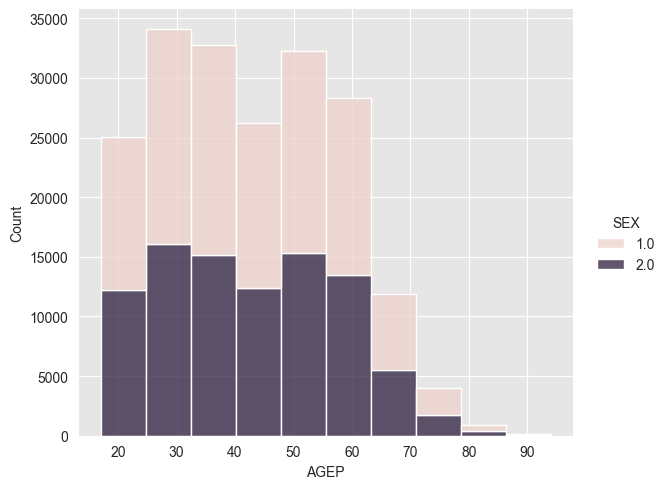

In [23]:
sns.displot(
    df,
    x="AGEP",
    hue="SEX",
    aspect=1.2,
    kind="hist",
    stat="count",
    bins=10,
    multiple="stack",
)
plt.show()

This visualization is not entirely conclusive; we can observe similar patters for both types of sex that are recorded in the data. This gives rise to the question whether there is a combination of attributes that leads to the bi-modal peaks we can observe.

We can also bin the age feature and split the plot by the model target. We would expect the younger age-groups to have lower salaries as they are more likely to still be in education or working lower salary jobs. To plot this, we can include a `col` parameter in `displot()`.

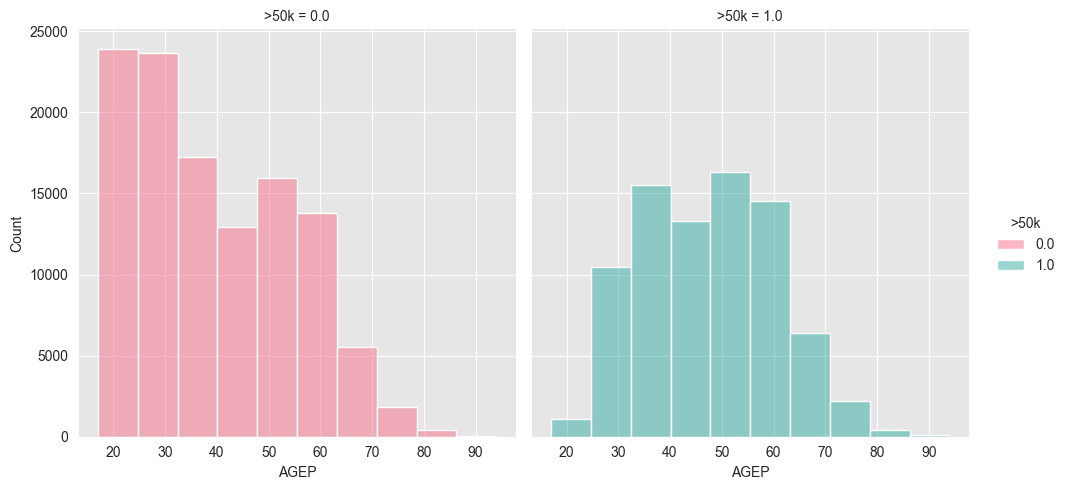

In [24]:
sns.displot(
    df,
    x="AGEP",
    col=model_target,
    bins=10,
    palette=sns.color_palette("husl", 2),
    hue=model_target,
)

plt.show()

The above is interesting as it suggest that we have different underlying age distributions for different outcome classes. We can look at this again by using the kernel density estimate option for plotting. 

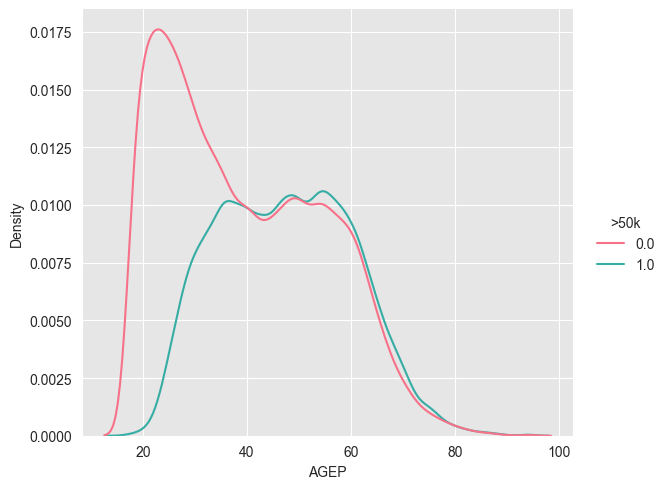

In [25]:
sns.displot(
    df,
    x="AGEP",
    hue=model_target,
    aspect=1.2,
    kind="kde",
    palette=sns.color_palette("husl", 2),
)
plt.show()

## 4. <a name="4">Scatter Plots</a>
(<a href="#0">Go to top</a>)

Scatter plots are simple 2D plots of two numerical variables that can be used to examine the relationship between two numerical variables. If one variable is moving up and so is the other, it is a so-called positive correlation. If one variable moves down and the other moves up, it is a negative correlation.

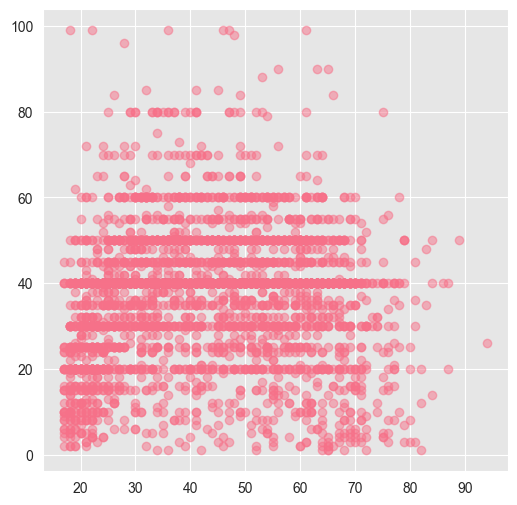

In [26]:
plt.figure(figsize=(6, 6))
plt.scatter(
    x="AGEP",
    y="WKHP",
    data=df.sample(
        5000, random_state=1
    ),  # we take a sample of data for quicker plotting
    alpha=0.5,
)
plt.show()

Looking at this plot, there is not really any particular relationship. Let's try to overlay the outcome with a sensitive attribute by specifying a `hue`.

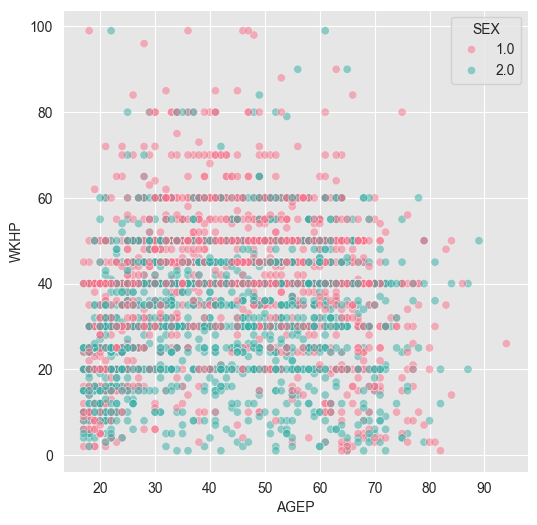

In [27]:
plt.figure(figsize=(6, 6))

sns.scatterplot(
    data=df.sample(
        5000, random_state=1
    ),  # we take a sample of data for quicker plotting
    x="AGEP",
    y="WKHP",
    hue="SEX",
    palette=sns.color_palette("husl", 2),
    alpha=0.5,
)

# Add legend
plt.show()

Now you can start to see a pattern for the different `SEX` attributes with class 1 showing up in the top half of the chart. The original goal was to look at the data split by `RAC1P` and you are now seeing that there is a second pattern emerging for another attribute (`SEX`). You can generally expect these effects to intersect; leading to amplified adverse effects for sub-populations with multiple sensitive attributes. Ultimately, you want to build ML models that also work for all sub-groups and this plot highlights why it is important to check whether there are multiple sensitive attributes in the data that are related to the outcome. In this particular case, you expect a correlation between hours worked and income, so let's quantify this in the next section.

## 5. <a name="5">Correlation Matrix</a>
(<a href="#0">Go to top</a>)

Similar to scatter plots, the correlation matrix aims to pinpoint relationships between numerical features. Correlation values of -1 means perfect negative correlation, 1 means perfect positive correlation, and 0 means there is no relationship between the two numerical features.

Text(0.5, 1.0, 'Correlation Matrix')

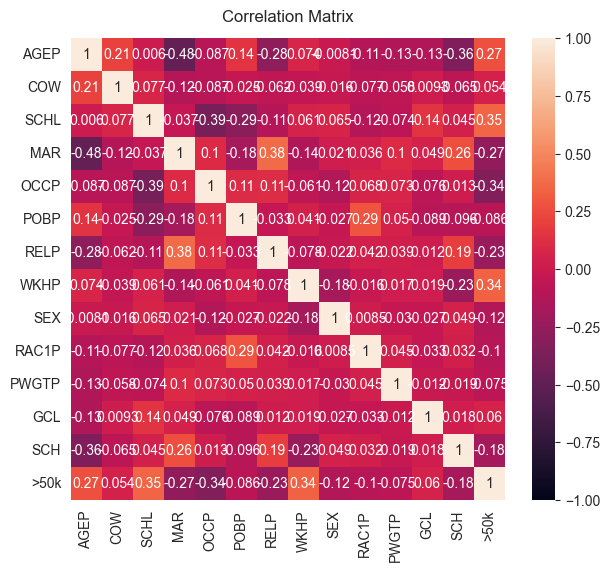

In [28]:
plt.figure(figsize=(7, 6))

heatmap = sns.heatmap(df.corr(), vmin=-1, vmax=1, annot=True)
heatmap.set_title("Correlation Matrix", fontdict={"fontsize": 12}, pad=12)

As expected, you see a positive correlation between age and salary as well as between hours worked and salary. However, does this also hold true if you split by sensitive feature?

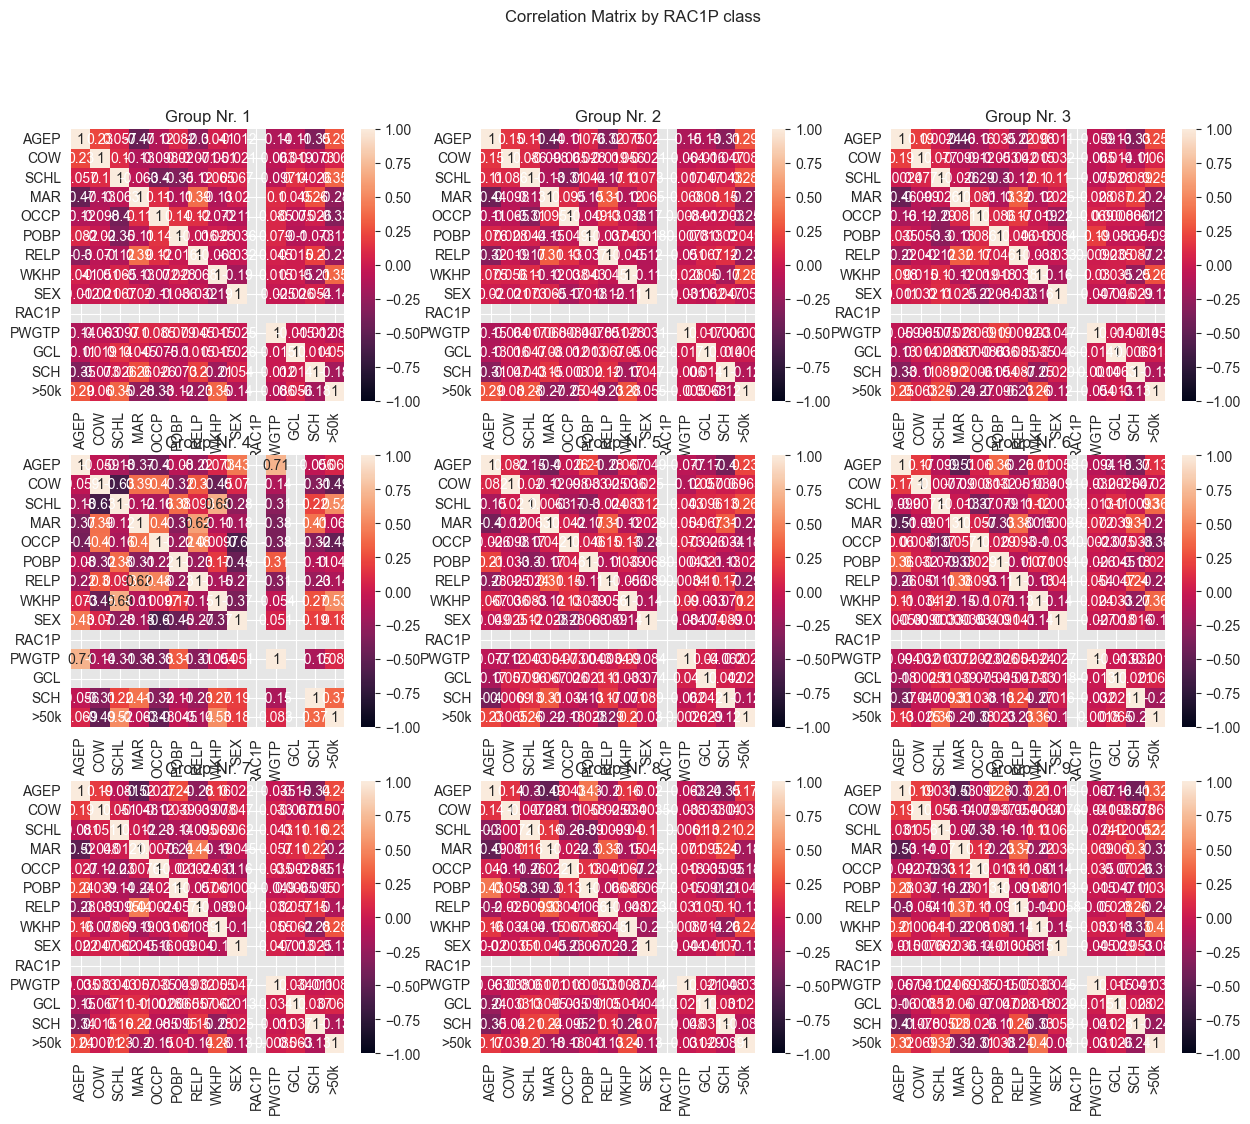

In [29]:
fig, axs = plt.subplots(nrows=3, ncols=3, figsize=(15, 12))
fig.suptitle("Correlation Matrix by RAC1P class")

tickers = sorted(df["RAC1P"].unique())
for i, ax in zip(tickers, axs.ravel()):
    sns.heatmap(
        df[df["RAC1P"] == i].corr(),
        ax=ax,
        vmin=-1,
        vmax=1,
        annot=True,
    )
    ax.set_title("Group Nr. %s" % str(int(i)))

Interestingly, age is less correlated with the outcome for certain groups. This could indicate, that being a member of a particular group has a bigger influence on the outcome than the age feature.

## 6. <a name="6">Difference in Proportion of Labels (DPL) and $CI_{norm}$</a>
(<a href="#0">Go to top</a>)

In this section, you will have a look at some specific measures that can help us identify bias in the dataset.

### Difference in Proportion of Labels
The difference in proportions of labels (DPL) compares the proportion of observed outcomes with positive labels for different groups in a dataset. More details about DPL can be found in the [SageMaker Clarify](https://docs.aws.amazon.com/sagemaker/latest/dg/clarify-data-bias-metric-true-label-imbalance.html) documentation.

$\large DPL = \frac{n_{>50k \wedge RAC1P=6}}{n_{RAC1P=6}} - \frac{n_{>50k \wedge RAC1P=8}}{n_{RAC1P=8}}$

To calculate DPL you need to select 2 groups that you want to compare. From the analysis in the beginning, you know that for the feature `RAC1P` group 6 and group 8 have the biggest relative difference in outcome, so you want to use those groups for further analysis. It is possible to calculate DPL for $> 2$ groups by selecting one reference group and then comparing against that particular group. It is also possible to use multiple attributes to establish group membership (`RAC1P` and `SEX`).

You can slice dataframe using logical conditions:

In [30]:
n_50k_gr6 = len(df[(df[">50k"] == 1) & (df["RAC1P"] == 6)])
n_gr6 = len(df[df["RAC1P"] == 6])

n_50k_gr8 = len(df[(df[">50k"] == 1) & (df["RAC1P"] == 8)])
n_gr8 = len(df[df["RAC1P"] == 8])

We can now calculate $DPL$. For binary and multi-categorical outcomes, the DPL values range over the interval (-1, 1). 

- Positive DPL values indicate that having attribute $a$ (e.g. group membership "6") has a higher proportion of positive outcomes when compared with not having attribute $a$ (e.g. group membership "8").

- Values of DPL near zero indicate a more equal proportion of positive outcomes between groups with different attributes

- Negative DPL values indicate that not having attribute $a$ has a higher proportion of positive outcomes when compared with having attribute $a$.

In [32]:
dpl = n_50k_gr6 / n_gr6 - n_50k_gr8 / n_gr8
dpl

0.2862397807230931

You observe DPL of $0.28$. This means members of group 6 has a higher proportion of positive outcomes.

### Class Imbalance (normalized)
Class imbalance (CI) occurs when there are different group sizes present in a dataset (groups based on sensitive attribute(s)). Here, you don't consider labels/outcomes and are focusing on the group sizes.

$\large CI_{norm} = \frac{n_{RAC1P=6}-n_{RAC1P=8}} {n_{RAC1P=6}+n_{RAC1P=8}}$

CI values range from -1 to +1.
- Positive CI values indicate that the group with attribute $a$ contains more examples than the other group
- CI values near 0 indicate that the groups are similar sizes
- Negative CI values indicate that the group with attribute $a$ contains fewer examples than the other group

Once again, you can use dataframe slicing to calculate the values. In fact, you can use `n_gr6` and `n_gr8` from the $DPL$ calculation as these are the counts you need.

In [30]:
ci_norm = (n_gr6 - n_gr8) / (n_gr6 + n_gr8)
ci_norm

0.17866022846023566

In terms of group size imbalance, you can see from the CI metric that there are more examples in our dataset from group 6 than 8. This will be very important to remember for next steps and also for model selection. You will have to specify that the model target is imbalanced and also the groups you want to consider are different sizes. Keep in mind that generally models improve the more data you can provide. The same holds true for group-specific performance. You are dealing with target imbalance and group imbalance!

This is the end of this notebook.